## 전처리한 데이터 가지고 오기

In [1]:
%pip install -q lightgbm scikit-learn optuna

Note: you may need to restart the kernel to use updated packages.


In [82]:
# ライブラリのインポート
import pandas as pd
import lightgbm as lgb
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import early_stopping, log_evaluation 

In [80]:
# データ読み込み
df = pd.read_csv('../data/combined_batches_cleaned_all_data_5.csv')

特徴量とラベルに分割

In [71]:
df['digit_ratio'] = df['digits_count'] / (df['url_len'] + 1e-5)
df['meta_density'] = df['meta_count'] / (df['duration_sec'] + 1e-5)
df['performance_ratio'] = df['SpeedIndex'] / (df['duration_sec'] + 1e-5)

# log変換対象
df['TTFB_log'] = np.log1p(df['TTFB'])
df['LCP_log'] = np.log1p(df['LCP'])
df['FCP_log'] = np.log1p(df['FCP'])
# df['TBT_log'] = np.log1p(df['TBT'])  # ただし0の多さには注意

# 元の列は除外して、log変換版のみ使用
drop_cols = ['TTFB', 'LCP', 'FCP']
df = df.drop(columns=drop_cols)

# ターゲットと特徴量の分離
y = df['url_type']
X = df.drop(columns=['url_type'])
# X = df.drop(columns=['url_type', 'url_len', 'letters_count','performance_score','title_count','is_domain_in_url'])
X = X.select_dtypes(include=['int64', 'float64', 'bool'])


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115944 entries, 0 to 115943
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   115944 non-null  object 
 1   url_type              115944 non-null  int64  
 2   url_len               115944 non-null  int64  
 3   letters_count         115944 non-null  int64  
 4   digits_count          115944 non-null  int64  
 5   special_chars_count   115944 non-null  int64  
 6   shortened             115944 non-null  int64  
 7   is_domain_in_url      115944 non-null  int64  
 8   secure_http           115944 non-null  int64  
 9   redirect_count        115944 non-null  int64  
 10  duration_sec          115944 non-null  float64
 11  meta_count            115944 non-null  float64
 12  link_count            115944 non-null  float64
 13  title_count           115944 non-null  float64
 14  has_title             115944 non-null  bool   
 15  

学習・検証データに分割

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

LightGBMデータ形式に変換

In [74]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

### Optunaによるハイパーパラメータチューニング

In [18]:
from sklearn.metrics import f1_score
import lightgbm as lgb
import optuna
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss'])

    param = {
        'objective': 'multiclass',
        'num_class': y.nunique(),
        'metric': 'multi_logloss',
        'boosting_type': boosting_type,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 128, 255),  # GPU互換範囲
        'verbosity': -1,
        'feature_pre_filter': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

    # GOSS以外なら bagging を追加
    if boosting_type != 'goss':
        param.update({
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
        })

    num_boost_round = trial.suggest_int('num_boost_round', 100, 1000)

    train_dataset = lgb.Dataset(X_train, label=y_train)
    valid_dataset = lgb.Dataset(X_test, label=y_test)

    model = lgb.train(
        param,
        train_dataset,
        valid_sets=[valid_dataset],
        num_boost_round=num_boost_round,
        callbacks=[
            early_stopping(stopping_rounds=30),
            log_evaluation(period=50)
        ]
    )

    preds = model.predict(X_test)
    pred_labels = preds.argmax(axis=1)
    f1 = f1_score(y_test, pred_labels, average='macro')
    return f1


# Optunaの探索開始
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# 最良パラメータの出力
print("🔧 Best parameters found by Optuna:")
print(study.best_params)


[I 2025-06-11 22:25:20,090] A new study created in memory with name: no-name-44db72ae-170a-403e-9186-1d5d85210cd9


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.39951
[100]	valid_0's multi_logloss: 0.361806
[150]	valid_0's multi_logloss: 0.351091
[200]	valid_0's multi_logloss: 0.347523
[250]	valid_0's multi_logloss: 0.344767
[300]	valid_0's multi_logloss: 0.343511
Did not meet early stopping. Best iteration is:
[313]	valid_0's multi_logloss: 0.342867


[I 2025-06-11 22:25:48,774] Trial 0 finished with value: 0.8563072906065816 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.1663098589823159, 'num_leaves': 135, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.7080235311060687, 'lambda_l1': 4.983395294105545, 'lambda_l2': 2.783882705558845, 'min_gain_to_split': 0.9411028281406336, 'max_bin': 135, 'num_boost_round': 317}. Best is trial 0 with value: 0.8563072906065816.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.416736
[100]	valid_0's multi_logloss: 0.391547
[150]	valid_0's multi_logloss: 0.388555
[200]	valid_0's multi_logloss: 0.386591
Early stopping, best iteration is:
[198]	valid_0's multi_logloss: 0.386575


[I 2025-06-11 22:26:00,352] Trial 1 finished with value: 0.8405763812784058 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11867569280969972, 'num_leaves': 119, 'max_depth': 12, 'min_data_in_leaf': 90, 'feature_fraction': 0.9445383931608121, 'lambda_l1': 4.9708517318578975, 'lambda_l2': 1.0336211854820427, 'min_gain_to_split': 0.8166203426450818, 'max_bin': 146, 'bagging_fraction': 0.8091096767136957, 'bagging_freq': 3, 'num_boost_round': 538}. Best is trial 0 with value: 0.8563072906065816.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.536581
[100]	valid_0's multi_logloss: 0.480462
[150]	valid_0's multi_logloss: 0.449905
[200]	valid_0's multi_logloss: 0.431029
[250]	valid_0's multi_logloss: 0.41712
[300]	valid_0's multi_logloss: 0.405937
[350]	valid_0's multi_logloss: 0.396863
[400]	valid_0's multi_logloss: 0.389588
[450]	valid_0's multi_logloss: 0.383445
[500]	valid_0's multi_logloss: 0.378542
[550]	valid_0's multi_logloss: 0.374441
[600]	valid_0's multi_logloss: 0.371037
[650]	valid_0's multi_logloss: 0.367817
[700]	valid_0's multi_logloss: 0.365183
[750]	valid_0's multi_logloss: 0.362383
[800]	valid_0's multi_logloss: 0.360687
[850]	valid_0's multi_logloss: 0.358665
[900]	valid_0's multi_logloss: 0.356962
[950]	valid_0's multi_logloss: 0.35534
Did not meet early stopping. Best iteration is:
[998]	valid_0's multi_logloss: 0.353336


[I 2025-06-11 22:26:26,200] Trial 2 finished with value: 0.8490146563900142 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.193103509487462, 'num_leaves': 87, 'max_depth': 4, 'min_data_in_leaf': 67, 'feature_fraction': 0.9638678750698776, 'lambda_l1': 4.732540921558115, 'lambda_l2': 3.48960393990482, 'min_gain_to_split': 0.03743741857342242, 'max_bin': 219, 'num_boost_round': 998}. Best is trial 0 with value: 0.8563072906065816.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.467576
[100]	valid_0's multi_logloss: 0.409499
[150]	valid_0's multi_logloss: 0.379836
[200]	valid_0's multi_logloss: 0.368416
Early stopping, best iteration is:
[201]	valid_0's multi_logloss: 0.36831


[I 2025-06-11 22:26:35,167] Trial 3 finished with value: 0.8456825944342962 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17856430830341893, 'num_leaves': 98, 'max_depth': 6, 'min_data_in_leaf': 13, 'feature_fraction': 0.9562373102698905, 'lambda_l1': 4.585690986953385, 'lambda_l2': 2.6438413775753213, 'min_gain_to_split': 0.21282531239339375, 'max_bin': 220, 'bagging_fraction': 0.9650132451673044, 'bagging_freq': 6, 'num_boost_round': 480}. Best is trial 0 with value: 0.8563072906065816.


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.68093
[100]	valid_0's multi_logloss: 0.580512
[150]	valid_0's multi_logloss: 0.538214
[200]	valid_0's multi_logloss: 0.513702
[250]	valid_0's multi_logloss: 0.496507
Did not meet early stopping. Best iteration is:
[269]	valid_0's multi_logloss: 0.490313


[I 2025-06-11 22:26:46,799] Trial 4 finished with value: 0.7986665636835178 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024808795147766488, 'num_leaves': 82, 'max_depth': 6, 'min_data_in_leaf': 49, 'feature_fraction': 0.9178864905784959, 'lambda_l1': 4.345658866286714, 'lambda_l2': 2.5747874881675763, 'min_gain_to_split': 0.734554670945501, 'max_bin': 149, 'bagging_fraction': 0.9434441475190828, 'bagging_freq': 4, 'num_boost_round': 269}. Best is trial 0 with value: 0.8563072906065816.


🔧 Best parameters found by Optuna:
{'boosting_type': 'goss', 'learning_rate': 0.1663098589823159, 'num_leaves': 135, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.7080235311060687, 'lambda_l1': 4.983395294105545, 'lambda_l2': 2.783882705558845, 'min_gain_to_split': 0.9411028281406336, 'max_bin': 135, 'num_boost_round': 317}


In [19]:
print("🔧 Best parameters found by Optuna:")
print(study.best_params)

🔧 Best parameters found by Optuna:
{'boosting_type': 'goss', 'learning_rate': 0.1663098589823159, 'num_leaves': 135, 'max_depth': 14, 'min_data_in_leaf': 97, 'feature_fraction': 0.7080235311060687, 'lambda_l1': 4.983395294105545, 'lambda_l2': 2.783882705558845, 'min_gain_to_split': 0.9411028281406336, 'max_bin': 135, 'num_boost_round': 317}


ハイパーパラメータ設定とモデル学習

In [75]:
# Optunaのベストパラメータに固定設定を追加
# best_params = study.best_params.copy()  # ← 上書き防止のため copy()

best_params = {'learning_rate': 0.25198045073380176, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 86, 'feature_fraction': 0.7139552624284528, 'bagging_fraction': 0.9483688703020394, 'bagging_freq': 1}
# GOSSの場合は bagging 系のパラメータを削除（LightGBMがエラーを出すため）
if best_params.get("boosting_type") == "goss":
    best_params.pop("bagging_fraction", None)
    best_params.pop("bagging_freq", None)

# 固定値を追加
best_params.update({
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'feature_pre_filter': False,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0
})

# Dataset 再作成（エラー回避＆安定性）
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

# モデル再学習（num_boost_round もチューニング結果から）
model = lgb.train(
    best_params,
    train_dataset,
    valid_sets=[train_dataset, valid_dataset],
    num_boost_round=best_params.get('num_boost_round', 100),
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=10)
    ]
)


Training until validation scores don't improve for 30 rounds
[10]	training's multi_logloss: 0.342241	valid_1's multi_logloss: 0.363537
[20]	training's multi_logloss: 0.259304	valid_1's multi_logloss: 0.297176
[30]	training's multi_logloss: 0.222867	valid_1's multi_logloss: 0.275629
[40]	training's multi_logloss: 0.197813	valid_1's multi_logloss: 0.264506
[50]	training's multi_logloss: 0.177248	valid_1's multi_logloss: 0.258032
[60]	training's multi_logloss: 0.160266	valid_1's multi_logloss: 0.253509
[70]	training's multi_logloss: 0.146133	valid_1's multi_logloss: 0.250894
[80]	training's multi_logloss: 0.133497	valid_1's multi_logloss: 0.248196
[90]	training's multi_logloss: 0.122285	valid_1's multi_logloss: 0.246396
[100]	training's multi_logloss: 0.112635	valid_1's multi_logloss: 0.246266
Did not meet early stopping. Best iteration is:
[99]	training's multi_logloss: 0.113428	valid_1's multi_logloss: 0.246195


予測と評価

In [77]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)
print("📊 Classification Report")
print(classification_report(y_test, y_pred))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n🧩 전체 클래스 간 오분류 분석")

# 클래스 목록 가져오기 (0,1,2 외의 클래스도 대응 가능)
classes = sorted(set(y_test) | set(y_pred))

# y_test와 y_pred가 시리즈일 경우를 고려하여 numpy 배열로 변환
y_true = y_test.values if isinstance(y_test, pd.Series) else y_test
y_pred_np = y_pred if not isinstance(y_pred, pd.Series) else y_pred.values

# 모든 클래스 쌍 (i ≠ j)에 대해 루프
for i in classes:
    for j in classes:
        if i == j:
            continue  # 정답인 경우는 건너뜀 (오분류만 분석)

        # i → j로 오분류된 인스턴스를 찾음
        misclassified_mask = (y_true == i) & (y_pred_np == j)

        if misclassified_mask.sum() > 0:
            print(f"\n🔍 클래스 {i} → 클래스 {j} 로 오분류된 인스턴스 수: {misclassified_mask.sum()}")
            print(X_test[misclassified_mask].describe())
        else:
            print(f"\n✅ 클래스 {i} → 클래스 {j} 오분류 없음")

📊 Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7709
           1       0.96      0.99      0.97      7884
           2       0.86      0.82      0.84      7596

    accuracy                           0.89     23189
   macro avg       0.89      0.89      0.89     23189
weighted avg       0.89      0.89      0.89     23189

🧩 Confusion Matrix
[[6672   46  991]
 [  11 7827   46]
 [1074  322 6200]]

🧩 전체 클래스 간 오분류 분석

🔍 클래스 0 → 클래스 1 로 오분류된 인스턴스 수: 46
          url_len  letters_count  digits_count  special_chars_count  \
count   46.000000      46.000000     46.000000            46.000000   
mean   105.391304      85.608696      8.173913            18.608696   
std     32.142377      27.628872      7.832424             5.039745   
min     76.000000      31.000000      0.000000            11.000000   
25%     81.250000      71.500000      2.000000            15.000000   
50%     95.000000      76.500000      6.0

重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

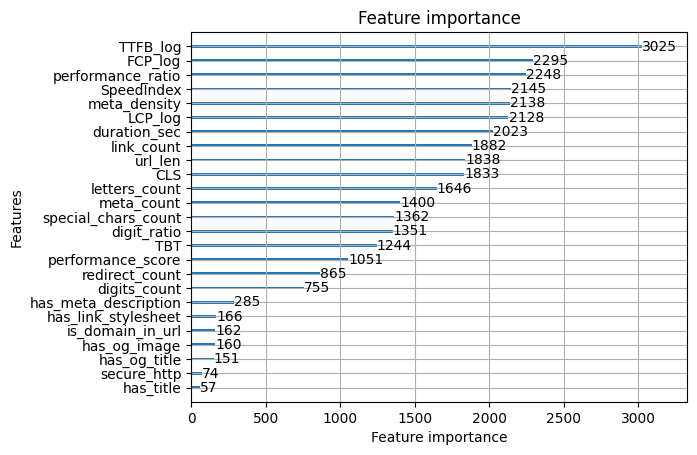

In [78]:
lgb.plot_importance(model, max_num_features=25)

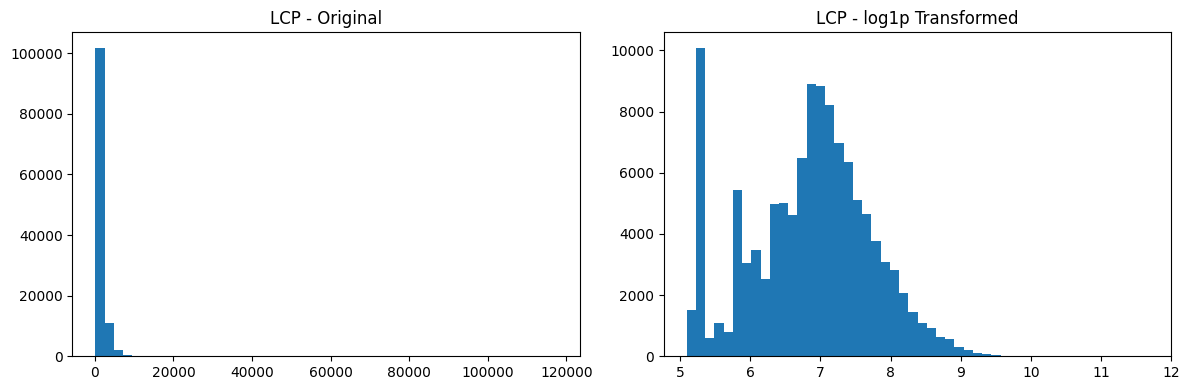

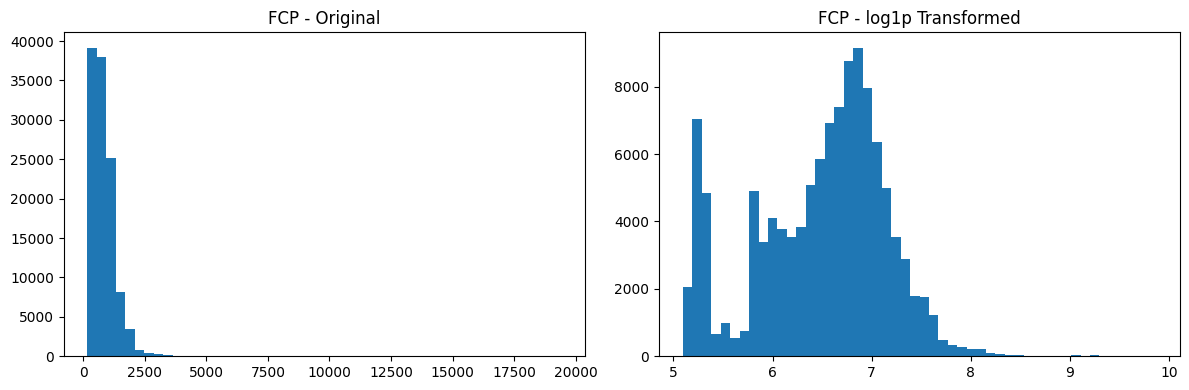

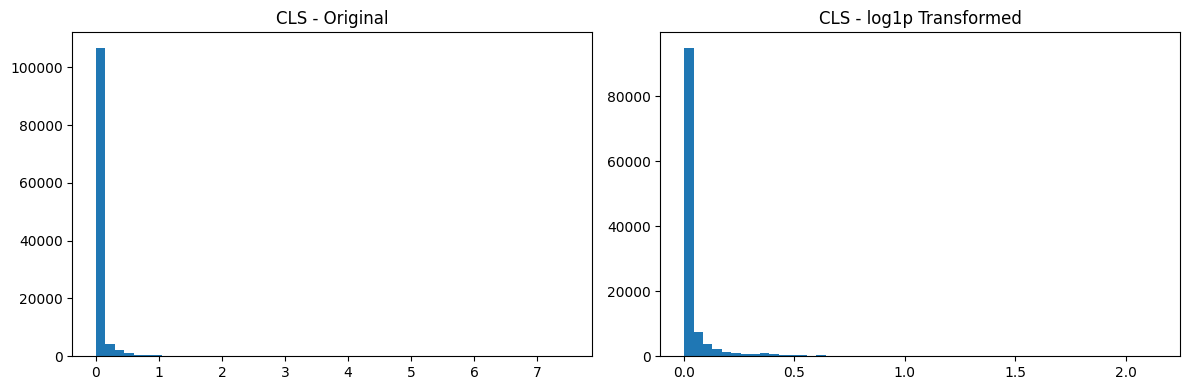

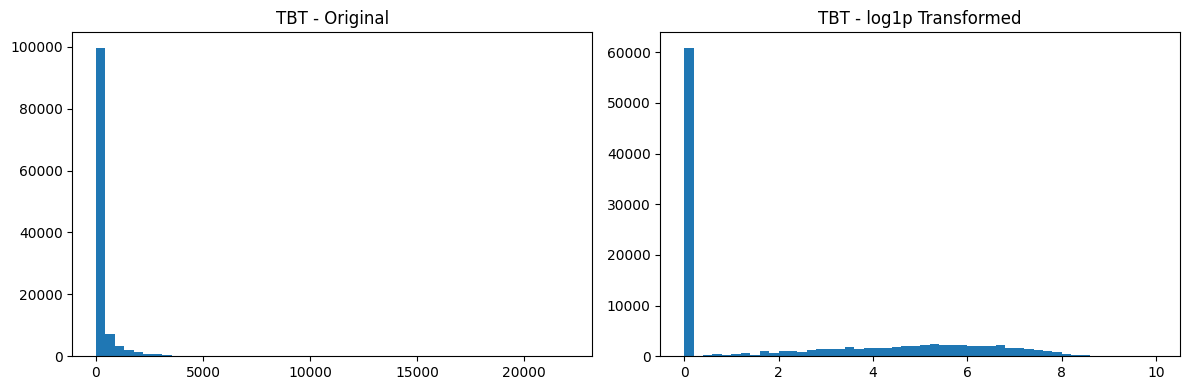

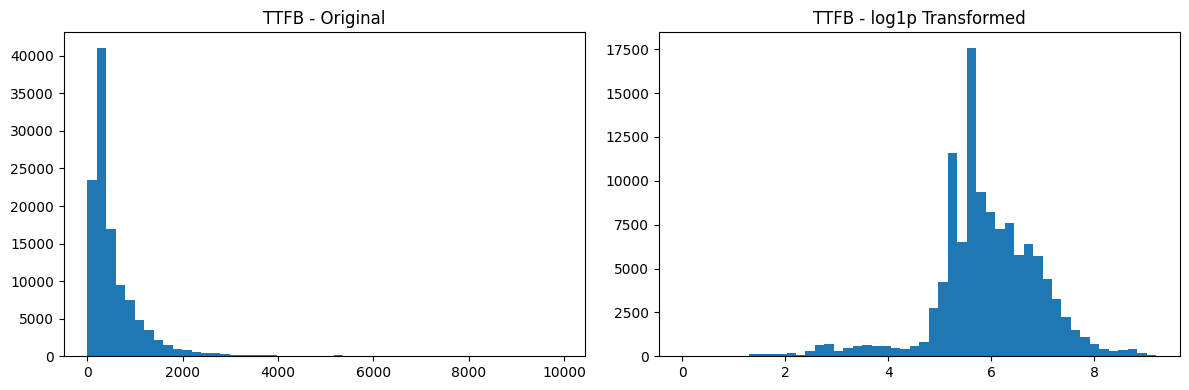

In [83]:
features_to_check = ["LCP", "FCP", "CLS", "TBT" , "TTFB"]

for feat in features_to_check:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[feat].dropna(), bins=50)
    plt.title(f"{feat} - Original")

    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df[feat].dropna()), bins=50)
    plt.title(f"{feat} - log1p Transformed")

    plt.tight_layout()
    plt.show()
